In [11]:
import torch, ultralytics
import os, glob, yaml, random, shutil
from pathlib import Path
from collections import Counter, defaultdict
from PIL import Image, ImageDraw
from IPython.display import display
from ultralytics import YOLO, RTDETR
import matplotlib.pyplot as plt
import pandas as pd

In [58]:
Data_Folder = "/Users/Admin/Desktop/12/Accident_Only"
Results_Folder = "/Users/Admin/Desktop/12//results_2"
yaml_to_use = "/Users/Admin/Desktop/12/Accident_Only/data.yaml"

In [59]:
DATA_ROOT = Path(Data_Folder)
YAML_PATH = Path(yaml_to_use)

In [60]:
# Load data.yaml
with open(YAML_PATH, "r", encoding="utf-8") as f:
    ycfg = yaml.safe_load(f)


In [61]:
import gc
gc.collect()
torch.cuda.empty_cache()
torch.backends.cudnn.benchmark = True

In [62]:
ycfg

{'train': '../train/images',
 'val': '../valid/images',
 'nc': 1,
 'names': ['Accident']}

In [63]:
# count images
print("Train images:", len(list((Path(DATA_ROOT)/"train/images").glob("*.jpg"))))
print("Train labels:", len(list((Path(DATA_ROOT)/"train/labels").glob("*.txt"))))
print("Val images:", len(list((Path(DATA_ROOT)/"valid/images").glob("*.jpg"))))
print("Val labels:", len(list((Path(DATA_ROOT)/"valid/labels").glob("*.txt"))))

Train images: 4242
Train labels: 4242
Val images: 162
Val labels: 162


In [64]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.backends.cudnn.version())
print(torch.cuda.is_available())
print(torch.cuda.device_count())

2.7.1+cu118
11.8
90100
True
1


Train

In [65]:
# Load model

model = YOLO("yolo11n.pt")
model.info()

YOLO11n summary: 181 layers, 2,624,080 parameters, 0 gradients, 6.6 GFLOPs


(181, 2624080, 0, 6.614336)

In [66]:
model.to("cuda")

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_

In [67]:
results = model.train(
    data=yaml_to_use,
    epochs=150,           
    imgsz=512,            
    batch=16,            
    lr0=3e-4,             
    lrf=0.01,             
    cos_lr=True,
    amp=True,
    freeze=0,
    mosaic=1.0,
    mixup=0.2,
    hsv_h=0.015, 
    hsv_s=0.7, 
    hsv_v=0.5,
    erasing=0.4,
    copy_paste=0.3,
    translate=0.1,
    auto_augment="randaugment",
    optimizer="AdamW",
    patience=15,
    label_smoothing=0.1,
    project=Results_Folder,
    device=0,
)


New https://pypi.org/project/ultralytics/8.3.221 available  Update with 'pip install -U ultralytics'
WARNING 'label_smoothing' is deprecated and will be removed in the future.
Ultralytics 8.3.213  Python-3.10.0 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4070 SUPER, 12282MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.3, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/Users/Admin/Desktop/12/Accident_Only/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=0, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.5, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0003, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.2, mode=train

# **Eval**

In [71]:
# RT-DETR evaluation
yolo_path = "/Users/Admin/Desktop/12/results_2/train/weights/best.pt"
yolo_model = YOLO(yolo_path)
yolo_metrics = yolo_model.val(data=YAML_PATH, save=True, project = Results_Folder)

Ultralytics 8.3.213  Python-3.10.0 torch-2.7.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4070 SUPER, 12282MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 648.2416.8 MB/s, size: 41.1 KB)
val: Scanning C:\Users\Admin\Desktop\12\Accident_Only\valid\labels.cache... 162 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 162/162  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 11/11 3.3it/s 3.4s<0.1s
                   all        162        163      0.905       0.89      0.924       0.63
Speed: 0.3ms preprocess, 16.6ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to C:\Users\Admin\Desktop\12\results_2\val


In [72]:
yolo_metrics.results_dict

{'metrics/precision(B)': 0.9045660031373927,
 'metrics/recall(B)': 0.8895705521472392,
 'metrics/mAP50(B)': 0.9236614504305913,
 'metrics/mAP50-95(B)': 0.6300689099975645,
 'fitness': 0.6300689099975645}

# **Visualizing the results**

In [51]:
# preview result images
def show_image(path, title=None):
    img = Image.open(path)
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()


**RT-DETR**

In [56]:
#  labels distribution
show_image(os.path.join(rtdetr_results, '/Users/Admin/Desktop/12/results/train2/val_batch2_labels.jpg'), 'Label distribution')
show_image(os.path.join(rtdetr_results, '/Users/Admin/Desktop/12/results/train2/val_batch2_pred.jpg'), 'Label distribution (Predicted)')

<Figure size 1000x800 with 1 Axes>

<Figure size 1000x800 with 1 Axes>

In [57]:
# confusion matrix
show_image(os.path.join(rtdetr_results, '/Users/Admin/Desktop/12/results/train2/confusion_matrix_normalized.png'), 'Confusion matrix')

<Figure size 1000x800 with 1 Axes>

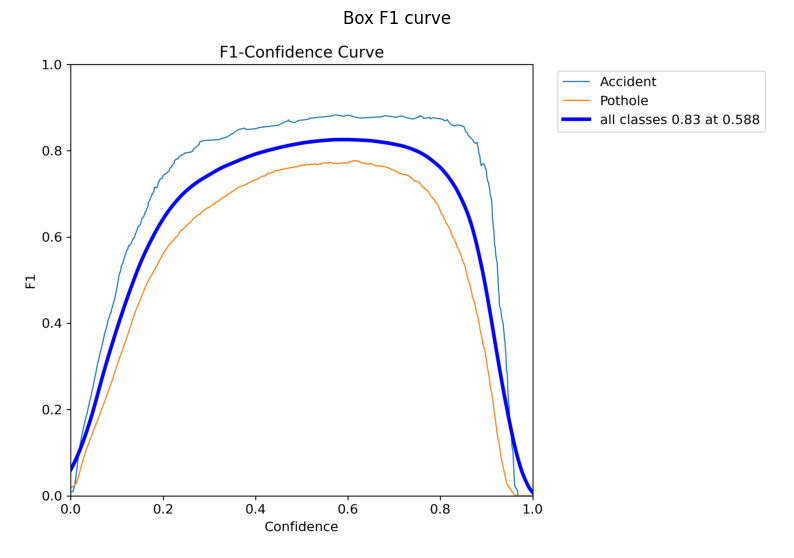

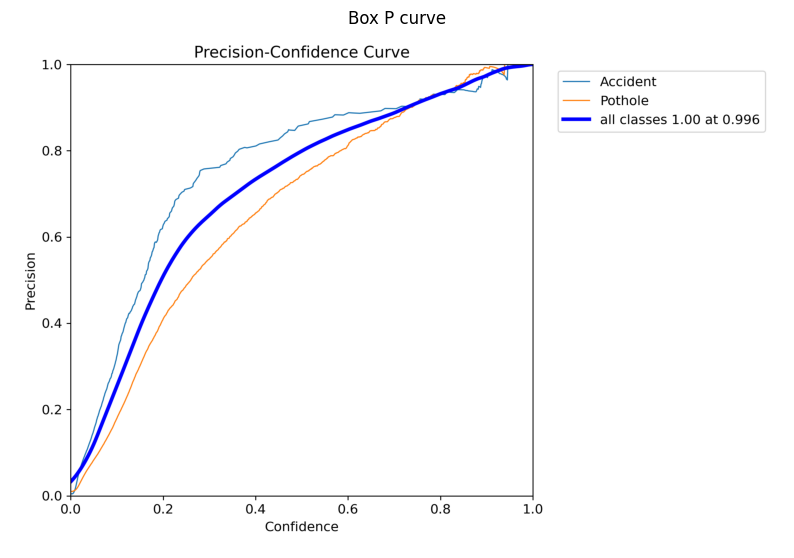

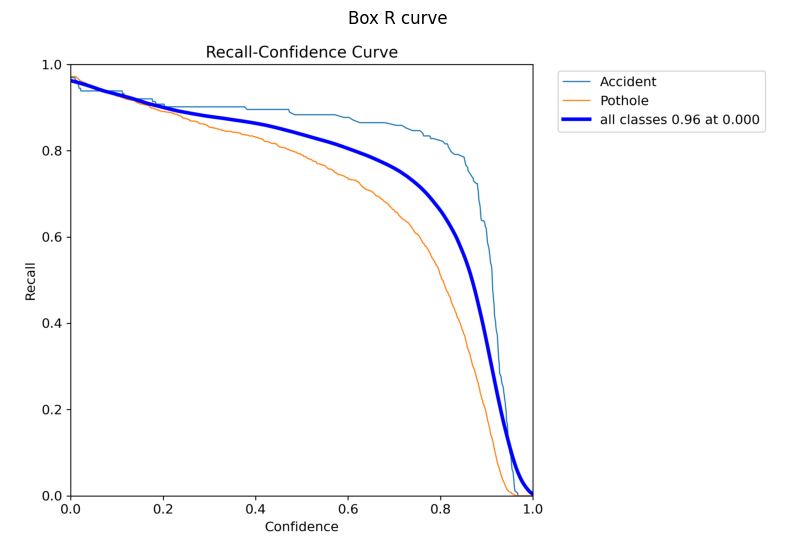

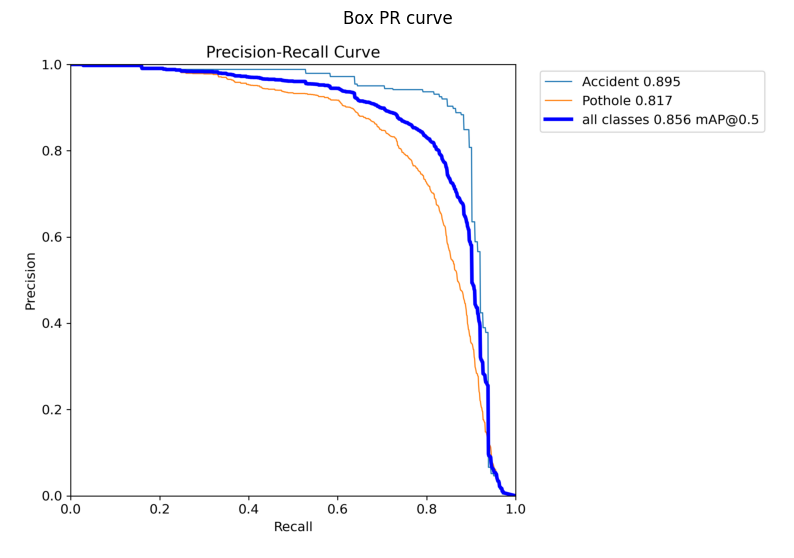

In [ ]:
# reulsts plots
show_image(os.path.join(rtdetr_results, 'val/BoxF1_curve.png'), 'Box F1 curve')
show_image(os.path.join(rtdetr_results, 'val/BoxP_curve.png'), 'Box P curve')
show_image(os.path.join(rtdetr_results, 'val/BoxR_curve.png'), 'Box R curve')
show_image(os.path.join(rtdetr_results, 'val/BoxPR_curve.png'), 'Box PR curve')

# **Inference**

In [19]:
weights_path = "/Users/Admin/Desktop/12/results_2/train/weights/best.pt"
model = YOLO(weights_path)

In [20]:
sample_data = "/Users/Admin/Desktop/12/samples"

**SAMPLE 1**

In [41]:
# SAMPLE 1 IMAGE
img_path = os.path.join(sample_data, "test.png")


image 1/1 c:\Users\Admin\Desktop\12\samples\test.png: 352x512 1 Accident, 49.1ms
Speed: 2.5ms preprocess, 49.1ms inference, 21.9ms postprocess per image at shape (1, 3, 352, 512)
Results saved to C:\Users\Admin\Desktop\12\results_2\inference


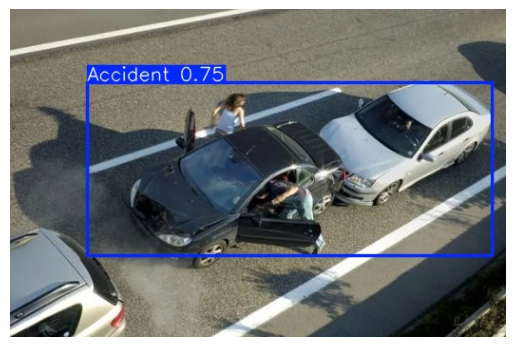

In [42]:
# Inference on image
yolo_result_pred = model.predict(
    source=img_path,
    conf=0.7,                      # confidence threshold
    iou=0.7,
    imgsz=512,
    save=True,                     # save annotated image
    show=True,
    project = "/Users/Admin/Desktop/12/results_2",
     name="inference",
    exist_ok=True
)

saved_path = os.path.join("/Users/Admin/Desktop/12/results_2/inference/test.jpg")
img = Image.open(saved_path)
plt.imshow(img)
plt.axis("off")
plt.show()


**SAMPLE 2**

In [34]:
# SAMPLE 2 IMAGE
img_path2 = os.path.join(sample_data, "test2.jpg")


image 1/1 c:\Users\Admin\Desktop\12\samples\test2.jpg: 288x512 (no detections), 7.9ms
Speed: 0.8ms preprocess, 7.9ms inference, 0.5ms postprocess per image at shape (1, 3, 288, 512)
Results saved to C:\Users\Admin\Desktop\12\results_2\inference


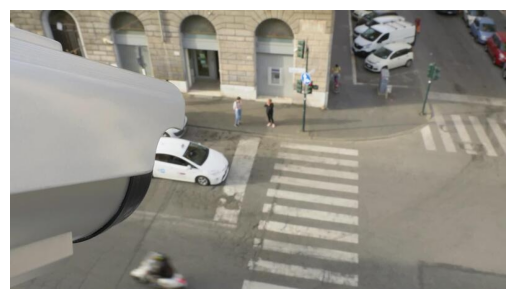

In [35]:
# Inference on image
yolo_result_pred = model.predict(
    source=img_path2,
    conf=0.7,                      # confidence threshold
    iou=0.7,
    imgsz=512,
    save=True,                     # save annotated image
    show=True,
    project = "/Users/Admin/Desktop/12/results_2",
     name="inference",
    exist_ok=True
)

saved_path = os.path.join("/Users/Admin/Desktop/12/results_2/inference/test2.jpg")
img = Image.open(saved_path)
plt.imshow(img)
plt.axis("off")
plt.show()

**SAMPLE 3**

In [ ]:
# SAMPLE 3 IMAGE
img_path3 = os.path.join(sample_data, "test3.jpg")


image 1/1 c:\Users\Admin\Desktop\12\samples\test3.jpg: 288x512 1 Accident, 8.5ms
Speed: 1.1ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 512)
Results saved to C:\Users\Admin\Desktop\12\results_2\inference


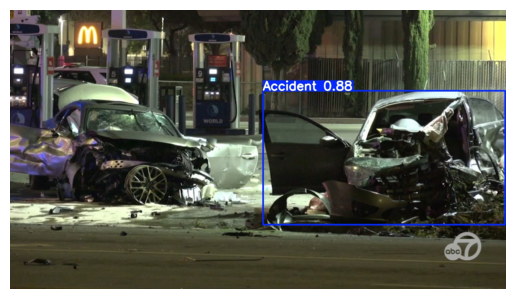

In [ ]:
# Inference on image
yolo_result_pred = model.predict(
    source=img_path3,
    conf=0.7,                      # confidence threshold
    iou=0.7,
    imgsz=512,
    save=True,                     # save annotated image
    show=True,
    project = "/Users/Admin/Desktop/12/results_2",
     name="inference",
    exist_ok=True
)

saved_path = os.path.join("/Users/Admin/Desktop/12/results_2/inference/test3.jpg")
img = Image.open(saved_path)
plt.imshow(img)
plt.axis("off")
plt.show()

**SAMPLE 4**

In [39]:
# SAMPLE 4 IMAGE
img_path4 = os.path.join(sample_data, "test4.jpg")


image 1/1 c:\Users\Admin\Desktop\12\samples\test4.jpg: 512x512 1 Accident, 143.6ms
Speed: 2.2ms preprocess, 143.6ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)
Results saved to C:\Users\Admin\Desktop\12\results_2\inference


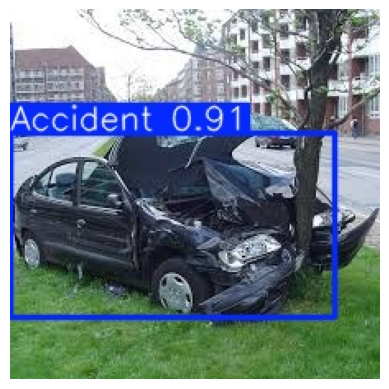

In [40]:
# Inference on image
yolo_result_pred = model.predict(
    source=img_path4,
    conf=0.7,                      # confidence threshold
    iou=0.7,
    imgsz=512,
    save=True,                     # save annotated image
    show=True,
    project = "/Users/Admin/Desktop/12/results_2",
     name="inference",
    exist_ok=True
)

saved_path = os.path.join("/Users/Admin/Desktop/12/results_2/inference/test4.jpg")
img = Image.open(saved_path)
plt.imshow(img)
plt.axis("off")
plt.show()